In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from scipy.signal import find_peaks_cwt
import pickle
%matplotlib inline

In [2]:
def abs_sobel_thresh(img, orient='x', sobel_kernel=3 ,thresh_min=0, thresh_max=255):
    
    # Apply the following steps to img
    # 1) Convert to grayscale
    
    # 2) Take the derivative in x or y given orient = 'x' or 'y'
    if orient == "x":
        sobel = cv2.Sobel(img,cv2.CV_64F,1,0,ksize=sobel_kernel)
    elif orient =="y":
        sobel = cv2.Sobel(img,cv2.CV_64F,0,1,ksize=sobel_kernel)
    else:
        pass
    # 3) Take the absolute value of the derivative or gradient
    abs_sobel = np.absolute(sobel)
    # 4) Scale to 8-bit (0 - 255) then convert to type = np.uint8
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # 5) Create a mask of 1's where the scaled gradient magnitude 
            # is > thresh_min and < thresh_max
    sbinary = np.zeros_like(scaled_sobel)
    sbinary[(scaled_sobel>=thresh_min)&(scaled_sobel<=thresh_max)]=1
    # 6) Return this mask as your binary_output image
    
    binary_output = sbinary # Remove this line
    return binary_output


def color_threshold_HSV(img, color_space,thresh=(0, 255)):
    
    # Apply the following steps to img
    # 1) Convert to grayscale
    HSV = cv2.cvtColor(img,cv2.COLOR_RGB2HSV)
    H= HSV[:,:,0]
    S= HSV[:,:,1]
    V = HSV[:,:,2]
    
    if color_space == "H":
        binary = np.zeros_like(H)
        binary[(H>=thresh[0])&(H<=thresh[1])]=1
        retval, color_space_binary = cv2.threshold(H.astype('uint8'), thresh[0], thresh[1], cv2.THRESH_BINARY)
        print("Color Space:",color_space)
    elif color_space=="S":
        binary = np.zeros_like(S)
        binary[(S>=thresh[0])&(S<=thresh[1])]=1
        retval, color_space_binary = cv2.threshold(S.astype('uint8'), thresh[0], thresh[1], cv2.THRESH_BINARY)
        print("Color Space:",color_space)
    elif color_space=="V":
        binary = np.zeros_like(V)
        binary[(V>=thresh[0])&(V<=thresh[1])]=1
        retval, color_space_binary = cv2.threshold(V.astype('uint8'), thresh[0], thresh[1], cv2.THRESH_BINARY)
        print("Color Space:",color_space)
    return color_space_binary

def warp(img):
    img_size=(img.shape[1],img.shape[0])
    src = np.float32( 
                        [[585. /1280.*img_size[0], 455./720.*img_size[1]],
                        [705. /1280.*img_size[0], 455./720.*img_size[1]],
                        [1120./1280.*img_size[0], 720./720.*img_size[1]],
                        [190. /1280.*img_size[0], 720./720.*img_size[1]]])
    dst = np.float32([[300. /1280.*img_size[0], 0./720.*img_size[1]],
                        [1000./1280.*img_size[0], 0./720.*img_size[1]],
                        [1000./1280.*img_size[0], 720./720.*img_size[1]],
                        [300. /1280.*img_size[0], 720./720.*img_size[1]]])
    
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
    return warped,M,Minv

def color_mask(color_space,low,high):
    mask = cv2.inRange(color_space, low, high)
    return mask
# apply color to the binary image
def apply_color_mask(color_space,img,low,high):
    mask = cv2.inRange(color_space, low, high)
    result = cv2.bitwise_and(img,img, mask= mask)
    return result

def moving_average(a, n=3):
    # Moving average
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

def lane_detection(lane_line_gb,mean_lane,thresh=0.005,which="left"):
    img_size =(lane_line_gb.shape[1],lane_line_gb.shape[0])
    arg_fsb = np.argwhere(mean_lane>thresh)
  
    if which  == "left":
        arg_fsb_L = arg_fsb[arg_fsb<img_size[0]/2.]
        if len(arg_fsb_L)==0:
            left_fit = left_fit_prev
        else:
            arg_fsb_L_min = np.min(arg_fsb_L)
            arg_fsb_L_max = np.max(arg_fsb_L)
            img_L = np.copy(lane_line_gb)
            img_L[:,0:arg_fsb_L_min] = 0
            img_L[:,arg_fsb_L_max:img_size[0]] = 0
        return img_L

    elif which =="right":
        arg_fsb_R = arg_fsb[arg_fsb>img_size[0]/2.]
        arg_fsb_R_min = np.min(arg_fsb_R)
        arg_fsb_R_max = np.max(arg_fsb_R)
        img_R = np.copy(lane_line_gb)
        img_R[:,0:arg_fsb_R_min] = 0
        img_R[:,arg_fsb_R_max:img_size[0]] = 0
        return img_R
    else:
        pass
    
def polyfit(line,thresh=0.8):
    global left_fit_prev   
    global right_fit_prev
    img_size = (line.shape[1],line.shape[0])
    vals = np.argwhere(line > thresh)
   
    all_x = vals.T[0]
    all_y =vals.T[1]

    fit = np.polyfit(all_x, all_y, 2)    
   
    y = np.arange(11)*img_size[1]/10
    fitx = fit[0] * y**2 + fit[1]*y + fit[2]
    left_fit_prev = left_fit
    return fitx,y,fit

def fit_cr(line,thresh=0.5):
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    img_size = (line.shape[1],line.shape[0])
    vals = np.argwhere(line > thresh)
    
    all_x = vals.T[0]
    all_y = vals.T[1]
    
    fit = np.polyfit(all_x*xm_per_pix, all_y*ym_per_pix, 2)
    return fit
 
def get_curvature(pol_a,y_pt):
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    A = pol_a[0]
    B = pol_a[1]
    R_curve = (1+(2*A*y_pt*ym_per_pix+B)**2)**1.5/np.absolute(2*A)
    return R_curve



def initial_mask(img,window_size):
    img_size=(img.shape[1],img.shape[0])
    mov_filtsize = img_size[1]/50.
    mean_lane = np.mean(img[img_size[1]/2:,:],axis=0)
    mean_lane = moving_average(mean_lane,mov_filtsize)
    
    #find peak indexes from histogram
    indexes = find_peaks_cwt(mean_lane,[100],max_distances=[800])
    
    
    val_ind = np.array([mean_lane[indexes[i]] for i in range(len(indexes)) ])
    ind_sorted = np.argsort(-val_ind)

    ind_peakR = indexes[ind_sorted[0]]
    ind_peakL = indexes[ind_sorted[1]]
    
    # exchange indexes if under condition
    if ind_peakR<ind_peakL:
        
        ind_peakR,ind_peakL = ind_peakL,ind_peakR

    # take windows from each index
    ind_min_L = ind_peakL-window_size
    ind_max_L = ind_peakL+window_size

    ind_min_R = ind_peakR-window_size
    ind_max_R = ind_peakR+window_size

    mask_L = np.zeros_like(img)
    mask_R = np.zeros_like(img)

    ind_peakR_prev = ind_peakR
    ind_peakL_prev = ind_peakL
    
    # Split image into 11 parts and compute histogram on each part
    
    for i in range(11):
        img_y1 = img_size[0]-img_size[0]*i/11
        img_y2 = img_size[0]-img_size[0]*(i+1)/11
    
        mean_lane_y = np.mean(img[img_y2:img_y1,:],axis=0)
        mean_lane_y = moving_average(mean_lane_y,mov_filtsize)
        indexes = find_peaks_cwt(mean_lane_y,[100], max_distances=[800])
        
        # if the indexes are more than 2 (both side peak L,R)
        if len(indexes)>1.5:
            val_ind = np.array([mean_lane[indexes[i]] for i in range(len(indexes)) ])
            ind_sorted = np.argsort(-val_ind)

            ind_peakR = indexes[ind_sorted[0]]
            ind_peakL = indexes[ind_sorted[1]]
            if ind_peakR<ind_peakL:
                ind_peakR,ind_peakL = ind_peakL,ind_peakR
            
        else:
        # if one peak is found
            if len(indexes)==1:
                #found right lane 
                if (np.abs(indexes[0]-ind_peakR_prev)<np.abs(indexes[0]-ind_peakL_prev)):
                    ind_peakR = indexes[0]
                    ind_peakL = ind_peakL_prev
                # found left lane
                else:
                    ind_peakL = indexes[0]
                    ind_peakR = ind_peakR_prev
            # If no pixels are found, use previous ones. 
            else:
                ind_peakL = ind_peakL_prev
                ind_peakR = ind_peakR_prev
            
            
        # If new center is more than 80pixels away, use previous
        # Outlier rejection
        if np.abs(ind_peakL-ind_peakL_prev)>=80:
            ind_peakL = ind_peakL_prev

        if np.abs(ind_peakR-ind_peakR_prev)>=80:
            ind_peakR = ind_peakR_prev
            
    
            
        mask_L[img_y2:img_y1,ind_peakL-window_size:ind_peakL+window_size] = 1.
        mask_R[img_y2:img_y1,ind_peakR-window_size:ind_peakR+window_size] = 1.
        
        ind_peakL_prev = ind_peakL
        ind_peakR_prev = ind_peakR
        
    return mask_L,mask_R

def get_mask_poly(img,poly_fit,window_size):
    mask_poly = np.zeros_like(img)
    img_size = np.shape(img)

    poly_pts = []
    pt_y_all = []

    for i in range(11):
        img_y1 = img_size[0]-img_size[0]*i/11
        img_y2 = img_size[0]-img_size[0]*(i+1)/11
        #polynomial fit 2nd order from 11 devided image
        pt_y = (img_y1+img_y2)/2
        pt_y_all.append(pt_y)
        poly_pt = np.round(poly_fit[0]*pt_y**2 + poly_fit[1]*pt_y + poly_fit[2])
    
        poly_pts.append(poly_pt)
    
        mask_poly[img_y2:img_y1,poly_pt-window_size:poly_pt+window_size] = 1.     

    return mask_poly, np.array(poly_pts),np.array(pt_y_all)

In [3]:
def pipeline(img):
    global left_fit_prev   
    global right_fit_prev
    global set_prev
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meteres per pixel in x dimension
    img_size=(img.shape[1],img.shape[0])
    mtx=np.array([[  7.52615043e+03,   0.00000000e+00,   4.69192259e+02],
                              [  0.00000000e+00,   7.86343209e+03,   2.73078310e+02],
                             [  0.00000000e+00,   0.00000000e+00,   1.00000000e+00]])
    dist = np.array([[ -9.92700922e+00,  -3.60394577e+02,   1.74434101e-01,
                                  2.34383103e-01,   3.07597893e+04]])
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    #warped,M,Minv = warp(img)
    warped,M,Minv = warp(undist)

    image_HSV = cv2.cvtColor(warped,cv2.COLOR_RGB2HSV)
    

    yellow_hsv_low  = np.array([ 0, 65, 80])
    yellow_hsv_high = np.array([ 80, 255, 255])

    white_hsv_low  = np.array([  0,   0,   180])
    white_hsv_high = np.array([ 255,  32, 255])

    yellow_lane = color_mask(image_HSV,yellow_hsv_low,yellow_hsv_high)
    white_lane = color_mask(image_HSV,white_hsv_low,white_hsv_high)
    
    sobelx=abs_sobel_thresh(undist)
    #sobelx=abs_sobel_thresh(img)
    
    lane_color = cv2.bitwise_or(yellow_lane,white_lane)
    lane_line = cv2.bitwise_or(sobelx,lane_color)
    lane_line_gb = cv2.GaussianBlur(lane_line,(9,9),0)/255.
    
    
    img_size=(lane_line_gb.shape[1],lane_line_gb.shape[0])
    mov_filtsize = img_size[1]/10.
    mean_lane = np.mean(lane_line_gb,axis=0)
    mean_lane= moving_average(mean_lane,mov_filtsize)

    arg_fsb = np.argwhere(mean_lane>.0045)

    arg_fsb_L = arg_fsb[arg_fsb<img_size[0]/2.]
    if len(arg_fsb_L)<5:
        left_fit = left_fit_prev
        
    else:
        arg_fsb_L_min = np.min(arg_fsb_L)
        arg_fsb_L_max = np.max(arg_fsb_L)
        img_L = np.copy(lane_line_gb)
        img_L[:,0:arg_fsb_L_min] = 0
        img_L[:,arg_fsb_L_max:img_size[0]] = 0
    
        vals = np.argwhere(img_L>.08)
        if len(vals)<5:
            left_fit = left_fit_prev
            
        else:

            all_x = vals.T[0]
            all_y =vals.T[1]
            small_left,large_left = np.percentile(all_y,[5,90])
            all_y = all_y[np.where((all_y>small_left) & (all_y<large_left))]
            all_x = all_x[np.where((all_y>small_left) & (all_y<large_left))]
            left_fit = np.polyfit(all_x, all_y, 2)
            left_fit_prev = left_fit
            left_fit_cr = np.polyfit(all_x*ym_per_pix, all_y*xm_per_pix, 2)
            y_eval = np.max(all_x)
            left_curverad = ((1 + (2*left_fit_cr[0]*y_eval + left_fit_cr[1])**2)**1.5) \
                                     /np.absolute(2*left_fit_cr[0])
    left_y = np.arange(9)*img_size[1]/8
    left_fitx = left_fit[0]*left_y**2 + left_fit[1]*left_y + left_fit[2]
    
    arg_fsb = np.argwhere(mean_lane>.029)
    arg_fsb_R = arg_fsb[arg_fsb>img_size[0]/2.]
  
    
    if len(arg_fsb_R)<10:
        right_fit = right_fit_prev
        print("right_fit")
        
    else:
        
        arg_fsb_R_min = np.min(arg_fsb_R)
        arg_fsb_R_max = np.max(arg_fsb_R)

        img_R = np.copy(lane_line_gb)
        img_R[:,0:arg_fsb_R_min] = 0
        img_R[:,arg_fsb_R_max:img_size[0]] = 0
    
    

        vals = np.argwhere(img_R>0.02)
        if len(vals)<10:
            right_fit = right_fit_prev
            print("prev_right")
        else:
            all_x = vals.T[0]
            all_y =vals.T[1]
            small_right,large_right = np.percentile(all_y,[3,100])
            
            all_y = all_y[np.where((all_y>small_right) & (all_y<large_right))]
            all_x = all_x[np.where((all_y>small_right) & (all_y<large_right))]


            right_fit = np.polyfit(all_x, all_y, 2)
            right_fit_prev = right_fit
            right_fit_cr = np.polyfit(all_x*ym_per_pix, all_y*xm_per_pix, 2)
            y_eval = np.max(all_x)
            right_curverad = ((1 + (2*right_fit_cr[0]*y_eval + right_fit_cr[1])**2)**1.5) \
                                     /np.absolute(2*right_fit_cr[0])
            
    right_y = np.arange(9)*img_size[1]/8
    right_fitx = right_fit[0]*right_y**2 + right_fit[1]*right_y + right_fit[2]
    
    right_fit_prev =right_fit
    
    if set_prev == 0:
        set_prev = 1
        right_fit_prev = right_fit
        left_fit_prev  = left_fit

    wpb_zero = np.zeros_like(lane_line_gb).astype(np.uint8)
    color_warp = np.dstack((wpb_zero, wpb_zero, wpb_zero))
    
    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, left_y]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, right_y])))])

    pts = np.hstack((pts_left, pts_right))
    

    middle = (left_fitx[-1] + right_fitx[-1])//2
    veh_pos = img_size[0]//2
    dist_offset =100* (veh_pos - middle)*xm_per_pix # Positive means the car is  on  the right side , Negative means on left
   


    # Draw the lane onto the warped blank image
    if dist_offset<30:
        cv2.fillPoly(color_warp, np.int_([pts]), (0,0,255))
    else:
        cv2.fillPoly(color_warp, np.int_([pts]), (255,0, 0))
        
    
    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (img.shape[1], img.shape[0])) 

    right_fit_prev = right_fit
    left_fit_prev  = left_fit
    
  
    
    middlepanel = np.zeros((120, 1280, 3), dtype=np.uint8)
    
    font = cv2.FONT_HERSHEY_COMPLEX
    result = cv2.addWeighted(undist, 1, newwarp, 0.6, 0)
    cv2.putText(result,'Left radius of curvature  = %.2f m'%(left_curverad),(50,50), font, 1,(255,255,255),2,cv2.LINE_AA)
    cv2.putText(result,'Right radius of curvature = %.2f m'%(right_curverad),(50,80), font, 1,(255,255,255),2,cv2.LINE_AA)
    cv2.putText(result,'Vehicle position : %.2f cm %s from center'%(abs(dist_offset), 'left' if dist_offset < 0 else 'right'),(50,120), 
                        font, 1,(255,255,255),2,cv2.LINE_AA)
    #cv2.putText(result, str_curv, (30, 60), font, 1, (255,0,0), 2)
    #cv2.putText(result, str_offset, (30, 90), font, 1, (255,0,0), 2)
    #result = cv2.addWeighted(img, 1, newwarp, 0.3, 0)
    return result

In [4]:
def pipeline(image):
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meteres per pixel in x dimension
    
    global mask_poly_L
    global mask_poly_R
    global right_fit_prev
    global left_fit_prev
    
    #print(set_prev)
    window_size=40
    warped,M,Minv = warp(image)
    img_size=(warped.shape[1],warped.shape[0])
    #warped,M,Minv = warp(image)
    image_HSV = cv2.cvtColor(warped,cv2.COLOR_RGB2HSV)
    yellow_hsv_low  = np.array([ 18, 80, 0])
    yellow_hsv_high = np.array([ 80, 255, 255])

    white_hsv_low  = np.array([  4,   0,   207])
    white_hsv_high = np.array([ 255,  32, 255])
    
    yellow_lane = color_mask(image_HSV,yellow_hsv_low,yellow_hsv_high)
    white_lane = color_mask(image_HSV,white_hsv_low,white_hsv_high)
    lane_color = cv2.bitwise_or(yellow_lane,white_lane)
    
    HLS = cv2.cvtColor(warped,cv2.COLOR_RGB2HLS)
    S= HLS[:,:,2]
    sobel_x = abs_sobel_thresh(S, orient='x', sobel_kernel=13 ,thresh_min=90, thresh_max=225)
    lane_line = cv2.bitwise_or(sobel_x,lane_color)
    image_cmb = np.zeros_like(lane_color)
    image_cmb[(lane_color>=.5)|(sobel_x>=0.5)]=1
    lane_line_gb = cv2.GaussianBlur(image_cmb,(9,9),0)
    
 
    mask_poly_L,mask_poly_R = initial_mask(lane_line_gb,window_size)
    
    #Left Line Detection
    img_L = np.copy(lane_line_gb)
    img_L = cv2.bitwise_and(lane_line_gb,lane_line_gb,
                                    mask = mask_poly_L)
    vals = np.argwhere(img_L>.3)
    if len(vals)<5: ## If less than 5 points 
        left_fit = left_fit_prev
        left_curverad = left_curverad_prev
        
       
       
    else:
        all_x = vals.T[0]
        all_y =vals.T[1]
        # Outlier detection (5 to 90 percentile of data is choosen)
        small_left,large_left = np.percentile(all_y,[5,90])
        all_y = all_y[np.where((all_y>small_left) & (all_y<large_left))]
        all_x = all_x[np.where((all_y>small_left) & (all_y<large_left))]
        left_fit = np.polyfit(all_x, all_y, 2)
    
        y_eval = np.max(all_x)
        left_fit_cr = np.polyfit(all_x*ym_per_pix, all_y*xm_per_pix, 2)
        left_curverad = ((1 + (2*left_fit_cr[0]*y_eval + left_fit_cr[1])**2)**1.5) \
                                     /np.absolute(2*left_fit_cr[0])
        left_curverad_prev = left_curverad
        
    
    #Right Lane Detection

    img_R = np.copy(lane_line_gb)
    img_R = cv2.bitwise_and(lane_line_gb,lane_line_gb,
                                    mask = mask_poly_R)
    vals = np.argwhere(img_R>.3)
    if len(vals)<5: ## If less than 5 points 
        right_fit = right_fit_prev
        
    else:
        all_x = vals.T[0]
        all_y =vals.T[1]
        # Outlier detection (1 to 95 percentile of data is choosen)
        small_right,large_right = np.percentile(all_y,[1,95])
        all_y = all_y[np.where((all_y>small_right) & (all_y<large_right))]
        all_x = all_x[np.where((all_y>small_right) & (all_y<large_right))]
        right_fit = np.polyfit(all_x, all_y, 2)
        y_eval = np.max(all_x)
        right_fit_cr = np.polyfit(all_x*ym_per_pix, all_y*xm_per_pix, 2)
        right_curverad = ((1 + (2*right_fit_cr[0]*y_eval + right_fit_cr[1])**2)**1.5) \
        /np.absolute(2*right_fit_cr[0])
        right_curverad_prev = right_curverad
        
 

    right_fit_prev = right_fit
    left_fit_prev  = left_fit
       
    
    mask_poly_L,left_pts,img_pts =get_mask_poly(lane_line_gb,left_fit,window_size)
    mask_poly_R,right_pts,img_pts =get_mask_poly(lane_line_gb,right_fit,window_size)
    
    left_y = np.arange(11)*img_size[1]/10
    left_fitx = left_fit[0]*left_y**2 + left_fit[1]*left_y + left_fit[2]
    right_y = np.arange(11)*img_size[1]/10
    right_fitx = right_fit[0]*right_y**2 + right_fit[1]*right_y + right_fit[2]

    warp_zero = np.zeros_like(lane_line_gb).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

        # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, left_y]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, right_y])))])
    pts = np.hstack((pts_left, pts_right))


    cv2.fillPoly(color_warp, np.int_([pts]), (0,0, 255))
   





    newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0])) 
    
    middle = (left_fitx[-1] + right_fitx[-1])//2
    veh_pos = img_size[0]//2
    dist_offset =100* (veh_pos - middle)*xm_per_pix # Positive means the car is  on  the right side , Negative means on left
   


    # Draw the lane onto the warped blank image
    if dist_offset<30:
        cv2.fillPoly(color_warp, np.int_([pts]), (0,0,255))
    else:
        cv2.fillPoly(color_warp, np.int_([pts]), (255,0, 0))
        
    
    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0])) 

    right_fit_prev = right_fit
    left_fit_prev  = left_fit
  
    
   
   
    
  
    
    middlepanel = np.zeros((120, 1280, 3), dtype=np.uint8)
    
    font = cv2.FONT_HERSHEY_COMPLEX
    result = cv2.addWeighted(image, 1, newwarp, 0.6, 0)
    cv2.putText(result,'Left radius of curvature  = %.2f m'%(left_curverad),(50,50), font, 1,(255,255,255),2,cv2.LINE_AA)
    cv2.putText(result,'Right radius of curvature = %.2f m'%(right_curverad),(50,80), font, 1,(255,255,255),2,cv2.LINE_AA)
    cv2.putText(result,'Vehicle position : %.2f cm %s from center'%(abs(dist_offset), 'left' if dist_offset < 0 else 'right'),(50,120), 
                        font, 1,(255,255,255),2,cv2.LINE_AA)
    return result

/Users/Ryosuke/anaconda/envs/Udacity/lib/python3.5/site-packages/ipykernel/__main__.py:155: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/Ryosuke/anaconda/envs/Udacity/lib/python3.5/site-packages/ipykernel/__main__.py:83: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/Ryosuke/anaconda/envs/Udacity/lib/python3.5/site-packages/ipykernel/__main__.py:84: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/Ryosuke/anaconda/envs/Udacity/lib/python3.5/site-packages/ipykernel/__main__.py:192: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/Ryosuke/anaconda/envs/Udacity/lib/python3.5/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWa

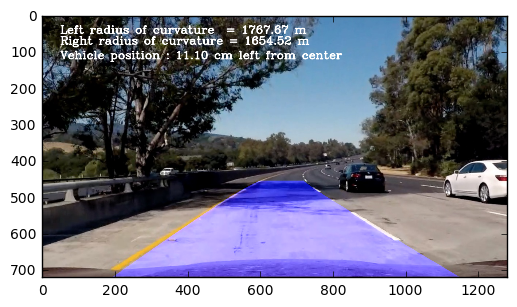

In [5]:
image= mpimg.imread('output_images/test5_undist.jpg')
result = pipeline(image)
plt.imshow(result)

In [6]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML
project_output = 'project.mp4'

clip_project = VideoFileClip("project_video.mp4")
project_clip = clip_project.fl_image(pipeline) #NOTE: this function expects color images!!
%time project_clip.write_videofile(project_output, audio=False)

[MoviePy] >>>> Building video project.mp4
[MoviePy] Writing video project.mp4


100%|█████████▉| 1260/1261 [10:19<00:00,  2.12it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project.mp4 

CPU times: user 15min 35s, sys: 48.3 s, total: 16min 23s
Wall time: 10min 21s


In [7]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(project_output))